In [831]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\icono\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Credit Status Dataset

## All features in a list with convenient type of data to use:
### Categorical
* <span style="color:red">ID</span>
* <span style="color:red">Customer_ID</span>
* Month (Can be converted to number or kept like this)
* <span style="color:red">Name</span>
* <span style="color:red">SSN</span>
* Occupation
* Type of Loan
* Credit_mix
* Payment behaviour
* Payment_of_min_amount

### Discrete
* Age
* Num_Bank_Accounts
* Interest Rate (Interest rate of loan)
* Num of Loan
* Delay_from_due_date
* Num_of_delayed_payment
* Num_Credit_Card	

### Continous
* Annual_Income
* Monthly_Inhand Salary
* Monthly_Balance
* Credit history age

We need a rule that can determine whether someone receives a credit or not, let's consider the following:
* Regular incomes.
* Enough payment capacity.
* Debt Ratio (Ratio de endeudamiento).
* Límite de capacidad de endeudamiento (Ingresos mensuales-Gastos Fijos) x0,40
* Number of bank accounts(More than 3 will be considered a risk)
* For discriminatory reasons, We won't consider ocuppation as a risk, we will focus more on other attributes.
* We will consider annual income divided by 12 instead of the monthly inhand salary, mainly because monthly inhand salary has a lot of missing values.It is relevant to consider annual income doesn't come with the same information that monthly inhand salary comes with.
* For the model, the Name won't matter to us as the number of loans already is enough to tell if someone should receive a credit or not.
* Interest rate can be relevant, however this does not determine whether someone gets a credit or not.
* The month 
#### Removing:
* ID
* Customer_ID
* Month
* Name
* Occupation
* Monthly Inhand Salary
* Interest Rate

We are missing the amount of loan that was asked.
The time needed for the payment to be concluded.

##### Here we insert pending rule function

In [832]:
#Insert rule function

#### Data Exploration, Data Cleaning and Data Preprocessing

##### Numeric data cleaning

In [833]:
df = pd.read_csv('https://raw.githubusercontent.com/mau-JS/OracleML/main/credit-status-dataset.csv')
#We create a temporary target before applying our rule to determine whether a credit is accepted or not.
df['Target'] = -1
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,Good,22 Years and 9 Months,No,Low_spent_Small_value_payments,186.2667021,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,Good,22 Years and 10 Months,No,High_spent_Medium_value_payments,361.4440039,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,Good,NaN,No,Low_spent_Medium_value_payments,264.6754462,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,Good,23 Years and 0 Months,No,High_spent_Medium_value_payments,343.8268732,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,1,Credit-Builder Loan,3,1,Good,27 Years and 3 Months,No,High_spent_Large_value_payments,485.2984337,-1


In [834]:
#For consistency and relevance, we convert years and months to continous values. Our years will be kept as discrete values and months as decimals.
def convert_to_years(s):
    years, months = 0, 0
    if isinstance(s, str):
        parts = s.split('and')
        if 'Year' in parts[0]:
            years = int(parts[0].split(' Year')[0])
        if len(parts) > 1 and 'Month' in parts[1]:
            months = int(parts[1].split(' Month')[0])
    return years + months / 12.0

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_to_years)

In [835]:
#This will help us notice what columns are numeric or not. This can tell us if we have to convert the data to other format or apply data cleaning.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,42502.0,4182.004291,3174.109304,303.645417,1625.188333,3086.305000,5934.189094,15204.63333
Num_Bank_Accounts,50000.0,16.838260,116.396848,-1.000000,3.000000,6.000000,7.000000,1798.00000
Num_Credit_Card,50000.0,22.921480,129.314804,0.000000,4.000000,5.000000,7.000000,1499.00000
Interest_Rate,50000.0,68.772640,451.602363,1.000000,8.000000,13.000000,20.000000,5799.00000
Delay_from_due_date,50000.0,21.052640,14.860397,-5.000000,10.000000,18.000000,28.000000,67.00000
Credit_History_Age,50000.0,17.244577,9.584866,0.000000,10.083333,17.916667,24.833333,34.00000
Target,50000.0,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000


Removing unknown symbols from Age and converting to numeric data

In [836]:
# Replacing non-numeric characters with an empty string
df['Age'] = df['Age'].str.replace(r'\D', '', regex=True)
# Convert the 'Age' column to a numeric type
df['Age'] = pd.to_numeric(df['Age'])

In [837]:
#Now age is with the proper format and with non numeric symbols removed.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,50000.0,118.994420,678.133254,14.000000,25.000000,34.000000,43.000000,8688.00000
Monthly_Inhand_Salary,42502.0,4182.004291,3174.109304,303.645417,1625.188333,3086.305000,5934.189094,15204.63333
Num_Bank_Accounts,50000.0,16.838260,116.396848,-1.000000,3.000000,6.000000,7.000000,1798.00000
Num_Credit_Card,50000.0,22.921480,129.314804,0.000000,4.000000,5.000000,7.000000,1499.00000
Interest_Rate,50000.0,68.772640,451.602363,1.000000,8.000000,13.000000,20.000000,5799.00000
Delay_from_due_date,50000.0,21.052640,14.860397,-5.000000,10.000000,18.000000,28.000000,67.00000
Credit_History_Age,50000.0,17.244577,9.584866,0.000000,10.083333,17.916667,24.833333,34.00000
Target,50000.0,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000


In [838]:
#There seems to be possible duplicates for Customer_ID, we must keep those that can be considered as a different transaction but should remove those
#that have same values.
#Removing duplicates where all transaction data is the same, yet ID is different. This allows us to prevent the user from spamming requests of credit.
cols = [col for col in df.columns if col != 'ID']

# Drop duplicates considering only the subset of columns
df = df.drop_duplicates(subset=cols)

#We drop duplicates where all values are the same.
df = df.drop_duplicates()
#This time there were no rows removed, however this data cleaning can be relevant if the dataset grows more.

We check if values that should be numerical, are really numerical.

In [839]:
#Looking at type of value.
print(df['Annual_Income'].dtypes)
#This prints "object" which means there are non numeric values.
#We convert all values to numeric.
df['Annual_Income'] = pd.to_numeric(df['Annual_Income'], errors='coerce')
#We print again to verify all values are numbers.
print(df['Annual_Income'].dtypes)

object
float64


We check again our dataset with describe.

In [840]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,50000.0,118.994420,6.781333e+02,14.000000,25.000000,34.000000,43.000000,8.688000e+03
Annual_Income,46480.0,165116.921762,1.341967e+06,7005.930000,19435.600000,37575.870000,72760.040000,2.413726e+07
Monthly_Inhand_Salary,42502.0,4182.004291,3.174109e+03,303.645417,1625.188333,3086.305000,5934.189094,1.520463e+04
Num_Bank_Accounts,50000.0,16.838260,1.163968e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,50000.0,22.921480,1.293148e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,50000.0,68.772640,4.516024e+02,1.000000,8.000000,13.000000,20.000000,5.799000e+03
Delay_from_due_date,50000.0,21.052640,1.486040e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Credit_History_Age,50000.0,17.244577,9.584866e+00,0.000000,10.083333,17.916667,24.833333,3.400000e+01
Target,50000.0,-1.000000,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00


We notice Num_of_Loan does not appear, so we have to convert it and clean it if needed.

In [841]:
# Replacing non-numeric characters with an empty string
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace(r'\D', '', regex=True)
# Convert the 'Age' column to a numeric type
df['Num_of_Loan'] = pd.to_numeric(df['Num_of_Loan'])
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,50000.0,118.994420,6.781333e+02,14.000000,25.000000,34.000000,43.000000,8.688000e+03
Annual_Income,46480.0,165116.921762,1.341967e+06,7005.930000,19435.600000,37575.870000,72760.040000,2.413726e+07
Monthly_Inhand_Salary,42502.0,4182.004291,3.174109e+03,303.645417,1625.188333,3086.305000,5934.189094,1.520463e+04
Num_Bank_Accounts,50000.0,16.838260,1.163968e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,50000.0,22.921480,1.293148e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,50000.0,68.772640,4.516024e+02,1.000000,8.000000,13.000000,20.000000,5.799000e+03
Num_of_Loan,50000.0,11.299360,6.548350e+01,0.000000,2.000000,3.000000,6.000000,1.496000e+03
Delay_from_due_date,50000.0,21.052640,1.486040e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Credit_History_Age,50000.0,17.244577,9.584866e+00,0.000000,10.083333,17.916667,24.833333,3.400000e+01
Target,50000.0,-1.000000,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00


Num_of_Delayed_Payment still does not appear as numeric.

In [842]:
# Replacing non-numeric characters with an empty string
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace(r'\D', '', regex=True)
# Convert the 'Age' column to a numeric type
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'])

Monthly Balance does not appear as numeric.

In [843]:
# Replacing non-numeric characters with an empty string
#11363
#print(df.iloc[11363])
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace(r'\D', '', regex=True)
#We convert to float as there are numbers that int can't handle.
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce', downcast='float')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,50000.0,1.189944e+02,6.781333e+02,14.000000,2.500000e+01,3.400000e+01,4.300000e+01,8.688000e+03
Annual_Income,46480.0,1.651169e+05,1.341967e+06,7005.930000,1.943560e+04,3.757587e+04,7.276004e+04,2.413726e+07
Monthly_Inhand_Salary,42502.0,4.182004e+03,3.174109e+03,303.645417,1.625188e+03,3.086305e+03,5.934189e+03,1.520463e+04
Num_Bank_Accounts,50000.0,1.683826e+01,1.163968e+02,-1.000000,3.000000e+00,6.000000e+00,7.000000e+00,1.798000e+03
Num_Credit_Card,50000.0,2.292148e+01,1.293148e+02,0.000000,4.000000e+00,5.000000e+00,7.000000e+00,1.499000e+03
Interest_Rate,50000.0,6.877264e+01,4.516024e+02,1.000000,8.000000e+00,1.300000e+01,2.000000e+01,5.799000e+03
Num_of_Loan,50000.0,1.129936e+01,6.548350e+01,0.000000,2.000000e+00,3.000000e+00,6.000000e+00,1.496000e+03
Delay_from_due_date,50000.0,2.105264e+01,1.486040e+01,-5.000000,1.000000e+01,1.800000e+01,2.800000e+01,6.700000e+01
Num_of_Delayed_Payment,46502.0,3.091037e+01,2.215075e+02,0.000000,9.000000e+00,1.400000e+01,1.800000e+01,4.399000e+03
Credit_History_Age,50000.0,1.724458e+01,9.584866e+00,0.000000,1.008333e+01,1.791667e+01,2.483333e+01,3.400000e+01


In the ‘Occupation’ column, some rows contain symbols instead of an occupation name. These symbols are placeholders indicating that the occupation is not specified. However, to maintain consistency and clarity in our data, it’s better to represent these unspecified values with 'Unknown'.

In [844]:
df.loc[df['Occupation'].str.isalpha() == False, 'Occupation'] = 'Unknown'
# Replace non-letter entries with None

In [845]:
#We remove irrelevant and sensitive data that we mentioned before.
df = df.drop(['ID','Customer_ID','Name','SSN','Month','Occupation','Monthly_Inhand_Salary','Interest_Rate'],axis=1)
df.head()

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,23,19114.12,3,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,Good,22.750000,No,Low_spent_Small_value_payments,1.862667e+09,-1
1,24,19114.12,3,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9.0,Good,22.833333,No,High_spent_Medium_value_payments,3.614440e+09,-1
2,24,19114.12,3,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4.0,Good,0.000000,No,Low_spent_Medium_value_payments,2.646754e+09,-1
3,24,19114.12,3,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5.0,Good,23.000000,No,High_spent_Medium_value_payments,3.438269e+09,-1
4,28,34847.84,2,4,1,Credit-Builder Loan,3,1.0,Good,27.250000,No,High_spent_Large_value_payments,4.852984e+09,-1


In [846]:
# Modifying rows where data is unknown
# Define your condition for 'Payment_Behaviour' in the original df
specified_values = ['low_spent_small_value_payments', 'low_spent_medium_value_payments', 'low_spent_large_value_payments', 'high_spent_small_value_payments', 'high_spent_medium_value_payments', 'high_spent_large_value_payments']

# Use the `.apply()` method to update the 'Payment_Behaviour' column (case-insensitive)
df['Payment_Behaviour'] = df['Payment_Behaviour'].apply(lambda x: x.lower() if x.lower() in specified_values else 'Unknown')

In [847]:
# Define the categories that matter
categories = ['Bad', 'Standard', 'Good']

# Replace all other categories with 'Unknown' in the 'Credit_Mix' column
df['Credit_Mix'] = np.where(df['Credit_Mix'].isin(categories), df['Credit_Mix'], 'Unknown')

#We create a copy so any modification to obtain the target does not affect our original dataframe
df_copy = df.copy()
df_copy

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,Target
0,23,19114.12,3,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,Good,22.750000,No,low_spent_small_value_payments,1.862667e+09,-1
1,24,19114.12,3,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9.0,Good,22.833333,No,high_spent_medium_value_payments,3.614440e+09,-1
2,24,19114.12,3,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4.0,Good,0.000000,No,low_spent_medium_value_payments,2.646754e+09,-1
3,24,19114.12,3,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5.0,Good,23.000000,No,high_spent_medium_value_payments,3.438269e+09,-1
4,28,34847.84,2,4,1,Credit-Builder Loan,3,1.0,Good,27.250000,No,high_spent_large_value_payments,4.852984e+09,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,4975,20002.88,10,8,5,"Personal Loan, Auto Loan, Mortgage Loan, Stude...",33,25.0,Unknown,0.000000,Yes,low_spent_small_value_payments,2.755396e+09,-1
49996,25,39628.99,4,6,2,"Auto Loan, and Student Loan",20,NaN,Good,31.916667,NM,low_spent_small_value_payments,4.093946e+09,-1
49997,25,39628.99,4,6,2,"Auto Loan, and Student Loan",23,5.0,Good,32.000000,No,low_spent_large_value_payments,3.497263e+09,-1
49998,25,39628.99,4,6,2,"Auto Loan, and Student Loan",21,6.0,Good,32.083333,No,high_spent_small_value_payments,4.632390e+08,-1


Function to determine target

In [848]:
def determine_target_based_on_columns(df):
    # Define your rules for determining the target based on specific columns
    # If 'Age' is between 25 and 60 (inclusive), 'Annual_Income' is greater than 25000, the user has 4 or fewer loans (excluding 'Not Specified' loans), 'Payment_Behaviour' is not one of the specified values (case-insensitive), 'Num_of_Delayed_Payment' is not more than 4, and 'Credit_Mix' is 'Good' or 'Standard,' set the target to 1 (accepted). Otherwise, set it to 0 (rejected).

    # Count the total number of loans (excluding 'Not Specified') for each user, while handling whitespace
    def count_loans(row):
        if pd.notna(row):
            # Split the row by ',' and strip whitespace from each element
            loans = [loan.strip() for loan in row.split(',') if loan.strip() != 'Not Specified']
            return len(loans)
        return 0

    # Function to handle 'Payment_Behaviour' values (case-insensitive)
    def handle_payment_behavior(behavior):
        specified_values = ['low_spent_low_value_payments', 'high_spent_small_value_payments']
        if behavior.lower() in specified_values:
            return 0
        return 1

    df['Total_Loans'] = df['Type_of_Loan'].apply(count_loans)
    df['Payment_Behaviour'] = df['Payment_Behaviour'].apply(lambda x: x.lower())
    df['Payment_Behaviour'] = df['Payment_Behaviour'].apply(handle_payment_behavior)
    
    # Set the target based on conditions, including 'Credit_Mix' condition
    target_series = ((df['Age'].between(24, 60)) & (df['Annual_Income'] >= 15000) & (df['Total_Loans'] <= 4) & (df['Payment_Behaviour'] == 1) & (df['Num_of_Delayed_Payment'] <= 4) & (df['Credit_Mix'].isin(['Good', 'Standard']))).astype(int)
    
    # Remove the temporary 'Total_Loans' column
    df.drop(columns=['Total_Loans'], inplace=True)
    
    return target_series
# Apply the rule function to compute the target variable for df_copy
df_copy['Target'] = determine_target_based_on_columns(df_copy)
#df_copy['Target']
# Count the number of accepted credits (where 'Target' is 1)
accepted_credits = df_copy['Target'].sum()

print(f"Number of accepted credits: {accepted_credits}")


Number of accepted credits: 2598


In [849]:
#Doing train test split before encoding to prevent data leakage
from sklearn.model_selection import train_test_split
loan_types = ['Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan',  'Mortgage Loan','Payday Loan','Student Loan','Debt Consolidation Loan','Not Specified','Payday Loan']

# Define your target variable
y = df_copy['Target']

# Define your feature set
X = df.drop('Target', axis=1)

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
# Create a new column for each loan type that counts the number of occurrences
for loan in loan_types:
    X_train[loan] = X_train['Type_of_Loan'].apply(lambda x: x.count(loan) if isinstance(x, str) else 0)
    X_test[loan] = X_test['Type_of_Loan'].apply(lambda x: x.count(loan) if isinstance(x, str) else 0)

# If a row doesn't fall into any of these categories, mark it as 'Not Specified'
X_train['Not Specified'] = X_train[loan_types].apply(lambda x: 0 if any(x) else 1, axis=1)
X_test['Not Specified'] = X_test[loan_types].apply(lambda x: 0 if any(x) else 1, axis=1)

# Now you can drop the original 'Type_of_Loan' column
X_train = X_train.drop('Type_of_Loan', axis=1)
X_test = X_test.drop('Type_of_Loan', axis=1)
X_train

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,...,Monthly_Balance,Auto Loan,Credit-Builder Loan,Personal Loan,Home Equity Loan,Mortgage Loan,Payday Loan,Student Loan,Debt Consolidation Loan,Not Specified
39087,54,46346.680,3,3,0,29,12.0,Unknown,19.750000,No,...,3.018253e+09,0,0,0,0,0,0,0,0,1
30893,500,9667.645,6,5,9,26,24.0,Bad,13.583333,Yes,...,2.465161e+08,1,1,1,2,2,0,2,0,0
45278,44,52487.140,7,5,3,5,21.0,Standard,18.000000,Yes,...,4.280790e+09,0,0,0,1,0,0,0,1,0
16398,410,34474.820,10,7,6,28,23.0,Unknown,1.583333,Yes,...,7.122716e+09,0,1,0,1,1,2,0,1,0
13653,22,26697.270,4,7,4,12,19.0,Standard,29.000000,Yes,...,3.454238e+09,0,2,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,22,63919.120,7,9,4,34,17.0,Bad,12.333333,Yes,...,2.180008e+09,0,0,0,0,0,1,1,1,0
44732,42,15497.020,8,4,2,19,14.0,Unknown,16.000000,Yes,...,3.121763e+09,0,0,0,1,0,0,0,1,0
38158,39,65050.320,8,5,6,36,13.0,Unknown,10.666667,Yes,...,2.070798e+09,3,1,1,0,0,1,0,0,0
860,54,34547.540,6,6,100,19,13.0,Good,22.833333,No,...,4.553983e+09,0,0,1,0,0,0,0,0,0


Fixing column names so they properly follow a format.

In [850]:
# Define English stopwords
stop_words = set(stopwords.words('english'))

# Define a function to clean column names
def clean_column_name(col_name):
    # Split the column name into words
    words = col_name.split()
    # Remove stopwords and capitalize the first letter of non-stopwords
    cleaned_name = ' '.join(word.title() if word not in stop_words else word for word in words)
    # Replace spaces with underscores
    cleaned_name = re.sub(r'\s+', '_', cleaned_name)
    return cleaned_name

# Apply the function to each column name in the training
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]
X_train

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_Of_Loan,Delay_From_Due_Date,Num_Of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_Of_Min_Amount,...,Monthly_Balance,Auto_Loan,Credit-Builder_Loan,Personal_Loan,Home_Equity_Loan,Mortgage_Loan,Payday_Loan,Student_Loan,Debt_Consolidation_Loan,Not_Specified
39087,54,46346.680,3,3,0,29,12.0,Unknown,19.750000,No,...,3.018253e+09,0,0,0,0,0,0,0,0,1
30893,500,9667.645,6,5,9,26,24.0,Bad,13.583333,Yes,...,2.465161e+08,1,1,1,2,2,0,2,0,0
45278,44,52487.140,7,5,3,5,21.0,Standard,18.000000,Yes,...,4.280790e+09,0,0,0,1,0,0,0,1,0
16398,410,34474.820,10,7,6,28,23.0,Unknown,1.583333,Yes,...,7.122716e+09,0,1,0,1,1,2,0,1,0
13653,22,26697.270,4,7,4,12,19.0,Standard,29.000000,Yes,...,3.454238e+09,0,2,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,22,63919.120,7,9,4,34,17.0,Bad,12.333333,Yes,...,2.180008e+09,0,0,0,0,0,1,1,1,0
44732,42,15497.020,8,4,2,19,14.0,Unknown,16.000000,Yes,...,3.121763e+09,0,0,0,1,0,0,0,1,0
38158,39,65050.320,8,5,6,36,13.0,Unknown,10.666667,Yes,...,2.070798e+09,3,1,1,0,0,1,0,0,0
860,54,34547.540,6,6,100,19,13.0,Good,22.833333,No,...,4.553983e+09,0,0,1,0,0,0,0,0,0


Age                           0
Annual_Income              2839
Num_Bank_Accounts             0
Num_Credit_Card               0
Num_Of_Loan                   0
Delay_From_Due_Date           0
Num_Of_Delayed_Payment     2807
Credit_Mix                    0
Credit_History_Age            0
Payment_Of_Min_Amount         0
Payment_Behaviour             0
Monthly_Balance             458
Auto_Loan                     0
Credit-Builder_Loan           0
Personal_Loan                 0
Home_Equity_Loan              0
Mortgage_Loan                 0
Payday_Loan                   0
Student_Loan                  0
Debt_Consolidation_Loan       0
Not_Specified                 0
dtype: int64


<Axes: >

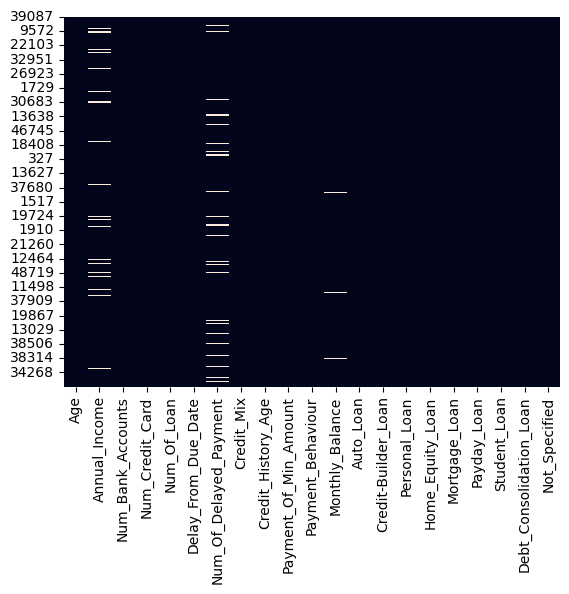

In [851]:
print(X_train.isnull().sum())
sns.heatmap(X_train.isnull(), cbar=False)

---

Data Imputation

In [852]:
# Create separate imputers for 'Annual_Income' and 'Num_of_Delayed_Payment'
imputer_income = SimpleImputer(strategy='median')
imputer_payment = SimpleImputer(strategy='median')
imputer_balance = SimpleImputer(strategy='median')
# Fit and transform 'Annual_Income' in training set
imputer_income.fit(X_train[['Annual_Income']])
X_train['Annual_Income'] = imputer_income.transform(X_train[['Annual_Income']])
X_test['Annual_Income'] = imputer_income.transform(X_test[['Annual_Income']])

# Fit and transform 'Num_of_Delayed_Payment' in training set
imputer_payment.fit(X_train[['Num_Of_Delayed_Payment']])
X_train['Num_Of_Delayed_Payment'] = imputer_payment.transform(X_train[['Num_Of_Delayed_Payment']])
X_test['Num_Of_Delayed_Payment'] = imputer_payment.transform(X_test[['Num_Of_Delayed_Payment']])

imputer_balance.fit(X_train[['Monthly_Balance']])
# Transform 'Monthly_Balance' column in the training set
X_train['Monthly_Balance'] = imputer_balance.transform(X_train[['Monthly_Balance']])

# Transform 'Monthly_Balance' column in the test set
X_test['Monthly_Balance'] = imputer_balance.transform(X_test[['Monthly_Balance']])
X_train

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_Of_Loan,Delay_From_Due_Date,Num_Of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_Of_Min_Amount,...,Monthly_Balance,Auto_Loan,Credit-Builder_Loan,Personal_Loan,Home_Equity_Loan,Mortgage_Loan,Payday_Loan,Student_Loan,Debt_Consolidation_Loan,Not_Specified
39087,54,46346.680,3,3,0,29,12.0,Unknown,19.750000,No,...,3.018253e+09,0,0,0,0,0,0,0,0,1
30893,500,9667.645,6,5,9,26,24.0,Bad,13.583333,Yes,...,2.465161e+08,1,1,1,2,2,0,2,0,0
45278,44,52487.140,7,5,3,5,21.0,Standard,18.000000,Yes,...,4.280790e+09,0,0,0,1,0,0,0,1,0
16398,410,34474.820,10,7,6,28,23.0,Unknown,1.583333,Yes,...,7.122716e+09,0,1,0,1,1,2,0,1,0
13653,22,26697.270,4,7,4,12,19.0,Standard,29.000000,Yes,...,3.454238e+09,0,2,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,22,63919.120,7,9,4,34,17.0,Bad,12.333333,Yes,...,2.180008e+09,0,0,0,0,0,1,1,1,0
44732,42,15497.020,8,4,2,19,14.0,Unknown,16.000000,Yes,...,3.121763e+09,0,0,0,1,0,0,0,1,0
38158,39,65050.320,8,5,6,36,13.0,Unknown,10.666667,Yes,...,2.070798e+09,3,1,1,0,0,1,0,0,0
860,54,34547.540,6,6,100,19,13.0,Good,22.833333,No,...,4.553983e+09,0,0,1,0,0,0,0,0,0


Age                        0
Annual_Income              0
Num_Bank_Accounts          0
Num_Credit_Card            0
Num_Of_Loan                0
Delay_From_Due_Date        0
Num_Of_Delayed_Payment     0
Credit_Mix                 0
Credit_History_Age         0
Payment_Of_Min_Amount      0
Payment_Behaviour          0
Monthly_Balance            0
Auto_Loan                  0
Credit-Builder_Loan        0
Personal_Loan              0
Home_Equity_Loan           0
Mortgage_Loan              0
Payday_Loan                0
Student_Loan               0
Debt_Consolidation_Loan    0
Not_Specified              0
dtype: int64


<Axes: >

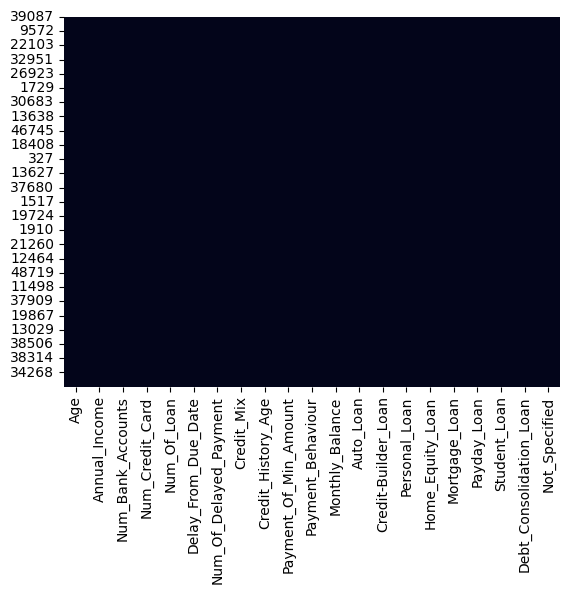

In [853]:
print(X_train.isnull().sum())
sns.heatmap(X_train.isnull(), cbar=False)

---

Ordinal Encoding for Credit_Mix.

In [854]:
from sklearn.preprocessing import OrdinalEncoder

# Create the encoder and specify the category ordering
encoder = OrdinalEncoder(categories=[['Bad','Unknown','Standard', 'Good']])

# Fit and transform the 'Credit_Mix' column in the training set
credit_mix_encoded_train = encoder.fit_transform(X_train[['Credit_Mix']])

# Transform the 'Credit_Mix' column in the test set
credit_mix_encoded_test = encoder.transform(X_test[['Credit_Mix']])

# Replace the original 'Credit_Mix' column with the encoded version in both sets
X_train['Credit_Mix'] = credit_mix_encoded_train
X_test['Credit_Mix'] = credit_mix_encoded_test
X_train

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_Of_Loan,Delay_From_Due_Date,Num_Of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_Of_Min_Amount,...,Monthly_Balance,Auto_Loan,Credit-Builder_Loan,Personal_Loan,Home_Equity_Loan,Mortgage_Loan,Payday_Loan,Student_Loan,Debt_Consolidation_Loan,Not_Specified
39087,54,46346.680,3,3,0,29,12.0,1.0,19.750000,No,...,3.018253e+09,0,0,0,0,0,0,0,0,1
30893,500,9667.645,6,5,9,26,24.0,0.0,13.583333,Yes,...,2.465161e+08,1,1,1,2,2,0,2,0,0
45278,44,52487.140,7,5,3,5,21.0,2.0,18.000000,Yes,...,4.280790e+09,0,0,0,1,0,0,0,1,0
16398,410,34474.820,10,7,6,28,23.0,1.0,1.583333,Yes,...,7.122716e+09,0,1,0,1,1,2,0,1,0
13653,22,26697.270,4,7,4,12,19.0,2.0,29.000000,Yes,...,3.454238e+09,0,2,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,22,63919.120,7,9,4,34,17.0,0.0,12.333333,Yes,...,2.180008e+09,0,0,0,0,0,1,1,1,0
44732,42,15497.020,8,4,2,19,14.0,1.0,16.000000,Yes,...,3.121763e+09,0,0,0,1,0,0,0,1,0
38158,39,65050.320,8,5,6,36,13.0,1.0,10.666667,Yes,...,2.070798e+09,3,1,1,0,0,1,0,0,0
860,54,34547.540,6,6,100,19,13.0,3.0,22.833333,No,...,4.553983e+09,0,0,1,0,0,0,0,0,0


In [855]:
# Create a new encoder for 'Payment_Of_Min_Amount'
payment_encoder = OrdinalEncoder(categories=[['No', 'NM', 'Yes']])

# Fit and transform the 'Payment_Of_Min_Amount' column in the training set
payment_encoded_train = payment_encoder.fit_transform(X_train[['Payment_Of_Min_Amount']])

# Transform the 'Payment_Of_Min_Amount' column in the test set
payment_encoded_test = payment_encoder.transform(X_test[['Payment_Of_Min_Amount']])

# Replace the original 'Payment_Of_Min_Amount' column with the encoded version in both sets
X_train['Payment_Of_Min_Amount'] = payment_encoded_train
X_test['Payment_Of_Min_Amount'] = payment_encoded_test

Converting to integers some values.

In [856]:
# Convert 'Credit_Mix' and 'Num_Of_Delayed_Payment' to integer
X_train['Credit_Mix'] = X_train['Credit_Mix'].astype(int)
X_train['Num_Of_Delayed_Payment'] = X_train['Num_Of_Delayed_Payment'].astype(int)

# Convert 'Credit_Mix' and 'Num_Of_Delayed_Payment' to integer
X_test['Credit_Mix'] = X_test['Credit_Mix'].astype(int)
X_test['Num_Of_Delayed_Payment'] = X_test['Num_Of_Delayed_Payment'].astype(int)

X_train['Payment_Of_Min_Amount'] = X_train['Payment_Of_Min_Amount'].astype(int)
X_test['Payment_Of_Min_Amount'] = X_test['Payment_Of_Min_Amount'].astype(int)

X_train

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_Of_Loan,Delay_From_Due_Date,Num_Of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_Of_Min_Amount,...,Monthly_Balance,Auto_Loan,Credit-Builder_Loan,Personal_Loan,Home_Equity_Loan,Mortgage_Loan,Payday_Loan,Student_Loan,Debt_Consolidation_Loan,Not_Specified
39087,54,46346.680,3,3,0,29,12,1,19.750000,0,...,3.018253e+09,0,0,0,0,0,0,0,0,1
30893,500,9667.645,6,5,9,26,24,0,13.583333,2,...,2.465161e+08,1,1,1,2,2,0,2,0,0
45278,44,52487.140,7,5,3,5,21,2,18.000000,2,...,4.280790e+09,0,0,0,1,0,0,0,1,0
16398,410,34474.820,10,7,6,28,23,1,1.583333,2,...,7.122716e+09,0,1,0,1,1,2,0,1,0
13653,22,26697.270,4,7,4,12,19,2,29.000000,2,...,3.454238e+09,0,2,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,22,63919.120,7,9,4,34,17,0,12.333333,2,...,2.180008e+09,0,0,0,0,0,1,1,1,0
44732,42,15497.020,8,4,2,19,14,1,16.000000,2,...,3.121763e+09,0,0,0,1,0,0,0,1,0
38158,39,65050.320,8,5,6,36,13,1,10.666667,2,...,2.070798e+09,3,1,1,0,0,1,0,0,0
860,54,34547.540,6,6,100,19,13,3,22.833333,0,...,4.553983e+09,0,0,1,0,0,0,0,0,0


---

#### Outliers removal

In [857]:
# Calculate Q1, Q2 and IQR
Q1 = X_train['Annual_Income'].quantile(0.25)
Q3 = X_train['Annual_Income'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Get outliers
outliers = X_train[(X_train['Annual_Income'] < lower_bound) | (X_train['Annual_Income'] > upper_bound)]

print(outliers)

        Age  Annual_Income  Num_Bank_Accounts  Num_Credit_Card  Num_Of_Loan  \
44127    42      147781.64                  0                4            0   
30501    40    19898609.00                  7                5            0   
21463    33      156429.52                  5                3            2   
29115    15    11896443.00                  7                9            2   
2645     21      173968.96                  4                7            1   
...     ...            ...                ...              ...          ...   
6873     30      166891.60                  1                6            1   
45758    36     9192132.00                  5                7            2   
9692   6409      161674.84                  1                5            4   
40757    39      145114.16                  1                7            0   
6265     51      159560.76                  3                1            1   

       Delay_From_Due_Date  Num_Of_Delayed_Payment 

In [858]:
#Removing outliers
X_train = X_train[(X_train['Annual_Income'] >= lower_bound) & (X_train['Annual_Income'] <= upper_bound)]
X_test = X_test[(X_test['Annual_Income'] >= lower_bound) & (X_test['Annual_Income'] <= upper_bound)]
X_train

,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Num_Of_Loan,Delay_From_Due_Date,Num_Of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_Of_Min_Amount,...,Monthly_Balance,Auto_Loan,Credit-Builder_Loan,Personal_Loan,Home_Equity_Loan,Mortgage_Loan,Payday_Loan,Student_Loan,Debt_Consolidation_Loan,Not_Specified
39087,54,46346.680,3,3,0,29,12,1,19.750000,0,...,3.018253e+09,0,0,0,0,0,0,0,0,1
30893,500,9667.645,6,5,9,26,24,0,13.583333,2,...,2.465161e+08,1,1,1,2,2,0,2,0,0
45278,44,52487.140,7,5,3,5,21,2,18.000000,2,...,4.280790e+09,0,0,0,1,0,0,0,1,0
16398,410,34474.820,10,7,6,28,23,1,1.583333,2,...,7.122716e+09,0,1,0,1,1,2,0,1,0
13653,22,26697.270,4,7,4,12,19,2,29.000000,2,...,3.454238e+09,0,2,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,22,63919.120,7,9,4,34,17,0,12.333333,2,...,2.180008e+09,0,0,0,0,0,1,1,1,0
44732,42,15497.020,8,4,2,19,14,1,16.000000,2,...,3.121763e+09,0,0,0,1,0,0,0,1,0
38158,39,65050.320,8,5,6,36,13,1,10.666667,2,...,2.070798e+09,3,1,1,0,0,1,0,0,0
860,54,34547.540,6,6,100,19,13,3,22.833333,0,...,4.553983e+09,0,0,1,0,0,0,0,0,0


---